In [1]:
!pip install scikit-optimize pandas numpy scikit-learn matplotlib seaborn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from skopt import BayesSearchCV


In [4]:
import os
print(os.listdir())  # Lista os arquivos na pasta atual

['.config', 'titanic (1).zip', 'sample_data']


In [5]:
import zipfile
import os

# Descompactar o arquivo ZIP (substitua 'seu_arquivo.zip' pelo nome correto)
with zipfile.ZipFile("titanic (1).zip", 'r') as zip_ref:
    zip_ref.extractall("titanic_data")

# Listar arquivos extraídos
print("Arquivos extraídos:", os.listdir("titanic_data"))


Arquivos extraídos: ['test.csv', 'train.csv', 'gender_submission.csv']


In [6]:
# Importar os dados
train_df = pd.read_csv("titanic_data/train.csv")
test_df = pd.read_csv("titanic_data/test.csv")

# Visualizar as primeiras linhas do conjunto de treino
print("Dados de treino:")
print(train_df.head())

# Visualizar as primeiras linhas do conjunto de teste
print("\nDados de teste:")
print(test_df.head())



Dados de treino:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

In [7]:
# Remover colunas irrelevantes
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# Preencher valores ausentes em 'Age' com a média
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

# Preencher valores ausentes em 'Embarked' com o mais frequente
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Converter variáveis categóricas em numéricas
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)

# Verificar os dados após a transformação
print(train_df.head())
print(test_df.head())


   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  
   Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
0       3  34.5      0      0   7.8292      True        True       False
1       3  47.0      1      0   7.0000     False       False        True
2       2  62.0      0      0   9.6875      True        True       False
3       3  27.0      0      0   8.6625      True       False        True
4       3  22.0      1      1  12.2875     False       False        True


<ipython-input-7-de49eae9c8de>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
<ipython-input-7-de49eae9c8de>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [9]:
# Separar rótulos (variável alvo) e features
X_train = train_df.drop(columns=['Survived'])  # Todas as colunas exceto "Survived"
y_train = train_df['Survived']  # Apenas a coluna "Survived"

X_test = test_df.copy()  # Os dados de teste não têm a coluna "Survived"

# Verificar as dimensões dos dados
print("Dimensão dos dados de treino:", X_train.shape)
print("Dimensão dos rótulos de treino:", y_train.shape)
print("Dimensão dos dados de teste:", X_test.shape)


Dimensão dos dados de treino: (891, 8)
Dimensão dos rótulos de treino: (891,)
Dimensão dos dados de teste: (418, 8)


In [10]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Definir os modelos
rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)

# Definir espaço de busca dos hiperparâmetros
param_grid_rf = {
    'n_estimators': (10, 200),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

param_grid_dt = {
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

# Criar otimizadores Bayesianos
opt_rf = BayesSearchCV(rf, param_grid_rf, n_iter=20, cv=5, random_state=42, n_jobs=-1)
opt_dt = BayesSearchCV(dt, param_grid_dt, n_iter=20, cv=5, random_state=42, n_jobs=-1)

# Treinar os modelos
opt_rf.fit(X_train, y_train)
opt_dt.fit(X_train, y_train)

# Melhor modelo e suas métricas
best_rf = opt_rf.best_estimator_
best_dt = opt_dt.best_estimator_

rf_score = cross_val_score(best_rf, X_train, y_train, cv=5).mean()
dt_score = cross_val_score(best_dt, X_train, y_train, cv=5).mean()

print("Melhor Random Forest Score:", rf_score)
print("Melhor Decision Tree Score:", dt_score)



Melhor Random Forest Score: 0.8305504990270542
Melhor Decision Tree Score: 0.8204883560354027


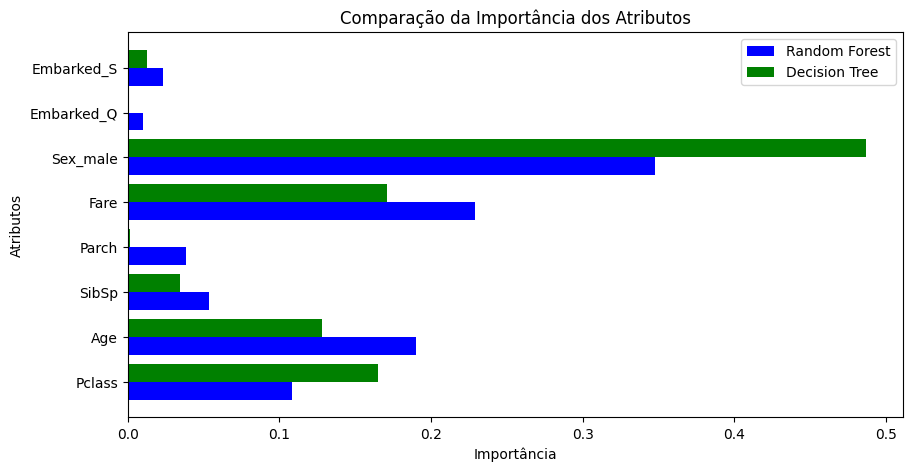

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Importância dos atributos para Random Forest
rf_importance = best_rf.feature_importances_
dt_importance = best_dt.feature_importances_

# Criar gráfico comparativo
features = X_train.columns
x = np.arange(len(features))

plt.figure(figsize=(10, 5))
plt.barh(x - 0.2, rf_importance, 0.4, label="Random Forest", color='blue')
plt.barh(x + 0.2, dt_importance, 0.4, label="Decision Tree", color='green')
plt.yticks(x, features)
plt.xlabel("Importância")
plt.ylabel("Atributos")
plt.title("Comparação da Importância dos Atributos")
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Fazer previsões com os modelos ajustados
y_pred_rf = best_rf.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

# Avaliar os modelos
print("Random Forest - Relatório de Classificação:")
print(classification_report(y_train, best_rf.predict(X_train)))

print("\nÁrvore de Decisão - Relatório de Classificação:")
print(classification_report(y_train, best_dt.predict(X_train)))



Random Forest - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       549
           1       0.93      0.83      0.88       342

    accuracy                           0.91       891
   macro avg       0.92      0.90      0.90       891
weighted avg       0.91      0.91      0.91       891


Árvore de Decisão - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       549
           1       0.87      0.79      0.83       342

    accuracy                           0.87       891
   macro avg       0.87      0.86      0.86       891
weighted avg       0.87      0.87      0.87       891

